In [50]:
import random
import os
import sys
import time
import numpy as np
import math
import zlib
from scipy.spatial import ConvexHull
from scipy.spatial import Delaunay

In [51]:
from CurveCGen import *
from CurveEA import *

In [52]:
import subprocess
BLENDER_PATH="C:\\Program Files\\Blender Foundation\\Blender 3.3\\blender.exe"

In [53]:
OUTPUT_PATH="E:\\Research\\Statue Generator\\Generations"

In [54]:
def shannon_entropy(file_path):
    with open(file_path, "rb") as f:
        bytes = f.read()
    prob = [float(bytes.count(b)) / len(bytes) for b in set(bytes)]
    entropy = -sum([p * math.log(p) / math.log(2.0) for p in prob])
    return round(entropy,6)

In [55]:
def golden_ratio(vertices, edges):
    def euclidean_distance(v1, v2):
        return ((v2[0] - v1[0])**2 + (v2[1] - v1[1])**2 + (v2[2] - v1[2])**2)**0.5
        
    golden_ratio = 1.61803398874989484820
    ratio_sum = 0
    ratio_count = 0
    
    for edge in edges:
        v1 = vertices[edge[0]]
        v2 = vertices[edge[1]]
        length = euclidean_distance(v1, v2)
        ratio = length / golden_ratio
        if ratio >= 1:
            ratio = 1 / ratio
        ratio_sum += ratio
        ratio_count += 1
    
    return ratio_sum / ratio_count


In [56]:
def perimeter(vertices, edges):
    perimeter = 0
    for edge in edges:
        vertex1, vertex2 = edge
        x1, y1, z1 = vertices[vertex1]
        x2, y2, z2 = vertices[vertex2]
        distance = np.sqrt((x2 - x1)**2 + (y2 - y1)**2 + (z2 - z1)**2)
        perimeter += distance
    return perimeter

In [57]:
def volume(vertices):
    vertices=np.array(vertices)
    tri = Delaunay(vertices)
    #print(tri.simplices)
    tetra = vertices[tri.simplices]
    volumes = np.zeros(len(tetra))

    for i, t in enumerate(tetra):
        a, b, c, d = t
        v = (1.0/6.0) * np.abs(np.dot(b - a, np.cross(c - a, d - a)))
        volumes[i] = v

    total_volume = np.sum(volumes)
    
    return total_volume

In [58]:
def compression_ratio(filepath):
    with open(filepath, mode="rb") as fin, open(filepath[:-6]+"_compressed", mode="wb") as fout:
            data = fin.read()
            compressed_data = zlib.compress(data, zlib.Z_BEST_COMPRESSION)
            orig=sys.getsizeof(data)
            comp=sys.getsizeof(compressed_data)
            ratio=comp/orig
    
            return ratio

In [59]:
def gen_blender(ARR,GEN_NUM):
    
    os.mkdir(OUTPUT_PATH+"\\GEN_"+str(GEN_NUM))
    
    for i,C in enumerate(ARR):
        
        #[r,g,b,a,bd,me,ro,ss,[VERTICES,EDGES],[new_L,new_B,new_H]]

        VERTS=C[8][0]
        EDGES=C[8][1]
        MATERIAL=str([C[0],C[1],C[2],C[3]])
        BD=str(C[4])
        ME=str(C[5])
        RO=str(C[6])
        SS=str(C[7])
        FILE_NUM=str(i)
        
        with open(f'{OUTPUT_PATH}\\GEN_{GEN_NUM}\\VERTS_G{GEN_NUM}_S{i}.txt', 'w') as f:
            f.writelines(str(VERTS))

        #subprocess.run(["blender", "--background", "--python","generate.py",FILE_NUM,f'VERTS_G{GEN_NUM}_S{i}.txt',MATERIAL,BD,ME,RO,SS,str(OUTPUT_PATH+"\\GEN_"+str(GEN_NUM))],capture_output=True,shell=True)
        #time.sleep(60)
        
        #print(f'Statue {i} Saved!')

## Basic Parameters for generation

In [60]:
L,B,H=10,12,17
POPULATION_SIZE=10

In [61]:
PARAMS=[]

## Initial Population

In [62]:
%%time

INITIAL_POPULATION=[]

for _ in range(POPULATION_SIZE):
    CH=generate_chromosome(L,B,H)
    INITIAL_POPULATION.append(CH)
    get_stats(CH)
    print('-'*125)

PARAMS.append(INITIAL_POPULATION)

(R, G, B, A) = (0.516283, 0.798182, 0.00248, 0.478371)
Number of vertices = 21
Number of edges = 20
Bevel Depth = 2.36
Metallic = 0.298054
Roughness = 0.375051
Subsurface Level = 0
New Bounding Box - (L,B,H) = (8.772425,6.347264,16.172722)
-----------------------------------------------------------------------------------------------------------------------------
(R, G, B, A) = (0.646431, 0.607775, 0.538165, 0.966108)
Number of vertices = 8
Number of edges = 7
Bevel Depth = 2.93
Metallic = 0.563571
Roughness = 0.410048
Subsurface Level = 4
New Bounding Box - (L,B,H) = (5.855061,10.704978,5.265809)
-----------------------------------------------------------------------------------------------------------------------------
(R, G, B, A) = (0.134982, 0.345442, 0.129927, 0.747517)
Number of vertices = 4
Number of edges = 3
Bevel Depth = 0.94
Metallic = 0.701255
Roughness = 0.473213
Subsurface Level = 6
New Bounding Box - (L,B,H) = (8.72345,1.12534,4.972488)
---------------------------------

In [63]:
%%time

os.mkdir(OUTPUT_PATH+"\\GEN_0")

for i,C in enumerate(PARAMS[0]):

    VERTS=C[8][0]
    EDGES=C[8][1]
    MATERIAL=str([C[0],C[1],C[2],C[3]])
    BD=str(C[4])
    ME=str(C[5])
    RO=str(C[6])
    SS=str(C[7])
    FILE_NUM=str(i)
    
    with open(f'{OUTPUT_PATH}\\GEN_0\\VERTS_G{0}_S{i}.txt', 'w') as f:
        f.writelines(str(VERTS))

    
    #subprocess.run(["blender", "--background", "--python","generate.py",FILE_NUM,f'VERTS_G0_S{i}.txt',MATERIAL,BD,ME,RO,SS,str(OUTPUT_PATH+"\\GEN_0")],capture_output=True,shell=True)

    #time.sleep(60)
    
    print(f'Statue {i} Saved!')
    

Statue 0 Saved!
Statue 1 Saved!
Statue 2 Saved!
Statue 3 Saved!
Statue 4 Saved!
Statue 5 Saved!
Statue 6 Saved!
Statue 7 Saved!
Statue 8 Saved!
Statue 9 Saved!
Wall time: 37.5 ms


## Crossover and Mutation for more generations

In [64]:
GENERATIONS=300

In [65]:
%%time

ALL_FITNESS=[]
BEST_FITNESS=[]
MUTATION_CHOICES=[]
GEN_NUM=1

for _ in range(GENERATIONS):
    
    PATH_FOR_PREV_GEN=OUTPUT_PATH+"\\GEN_"+str(GEN_NUM-1)
    FITNESS=[]
    
    for i in range(POPULATION_SIZE):
        
        VERTS=PARAMS[GEN_NUM-1][i][8][0]
        EDGES=PARAMS[GEN_NUM-1][i][8][1]
        
#         entropy=shannon_entropy(PATH_FOR_PREV_GEN+f"\\STATUE_{i}.blend")
#         entropy=entropy/8 
        
#         cr=compression_ratio(PATH_FOR_PREV_GEN+f"\\STATUE_{i}.blend")
        
#         gr=golden_ratio(VERTS,EDGES)
        
        v=volume(VERTS)
        p=perimeter(VERTS,EDGES)
#         print(f"Volume: {v}")
#         print(f"Perimeter: {p}")
    
        #fitness=volume+perimeter
        fitness=p/v
        FITNESS.append(round(fitness,6))
    
    ALL_FITNESS.append(FITNESS)
    
    BEST_FITNESS.append(FITNESS.index(max(FITNESS)))
    print(f'Statue-{FITNESS.index(max(FITNESS))} has the best fitness value in {GEN_NUM-1} generation.')
    
    MODELS=[]
    
    GEN_MUTATION=[]
    
    for _ in range(int(POPULATION_SIZE/2)):
    
        #selecting 2 random parents from previous generation
        idx1,idx2=random.randint(0,POPULATION_SIZE-1),random.randint(0,POPULATION_SIZE-1)
        p1=idx1 if FITNESS[idx1]>FITNESS[idx2] else idx2
        
        idx3,idx4=random.randint(0,POPULATION_SIZE-1),random.randint(0,POPULATION_SIZE-1)
        p2=idx3 if FITNESS[idx3]>FITNESS[idx4] else idx4
        
        crossover_prob=round(random.random(),6)
        mutation_prob=round(random.random(),6)
        
        if mutation_prob<0.2:
            #mutate the children after crossover
            m1,choice1=mutate(PARAMS[GEN_NUM-1][p1],L,B,H)
            m2,choice2=mutate(PARAMS[GEN_NUM-1][p2],L,B,H)
            
            GEN_MUTATION.append(choice1)
            GEN_MUTATION.append(choice2)
            
        else:
            m1,m2=PARAMS[GEN_NUM-1][p1],PARAMS[GEN_NUM-1][p2]
        
        if crossover_prob<0.2:
            #perform crossover for the selected parents
            c1,c2=crossover(m1,m2)
        else:
            c1,c2=m1,m2
        
        
        MODELS.append(c1)
        MODELS.append(c2)
        
    #print(len(MODELS))
    #appending the mutated childs to PARAMS array
    PARAMS.append(MODELS)
    
    #appending mutation choices
    MUTATION_CHOICES.append(GEN_MUTATION)
    
    #generate blender file
    gen_blender(MODELS,GEN_NUM)
    
    print(f"Generation {GEN_NUM} generated successfully!")
    print("-"*120)
    
    GEN_NUM+=1

Statue-7 has the best fitness value in 0 generation.


NameError: name 'j' is not defined

In [66]:
%%time
PATH_FOR_PREV_GEN=OUTPUT_PATH+"\\GEN_"+str(GENERATIONS)
FINAL_FITNESS=[]

for i in range(POPULATION_SIZE):

#     entropy=shannon_entropy(PATH_FOR_PREV_GEN+f"\\STATUE_{i}.blend")
#     entropy=entropy/8

    VERTS=PARAMS[GEN_NUM-1][i][8][0]
    EDGES=PARAMS[GEN_NUM-1][i][8][1]
    v=volume(VERTS)
    p=perimeter(VERTS,EDGES)
#         print(f"Volume: {v}")
#         print(f"Perimeter: {p}")
    
    #fitness=volume+perimeter
    fitness=p/v
    FINAL_FITNESS.append(round(fitness,6))

Wall time: 76.8 ms


In [67]:
FINAL_FITNESS

[0.508392,
 1.322197,
 7.274579,
 1.865171,
 0.548138,
 6.994008,
 0.374387,
 337.886337,
 0.930902,
 1.119812]

In [68]:
ALL_FITNESS.append(FINAL_FITNESS)

In [69]:
BEST_FITNESS.append(FINAL_FITNESS.index(max(FINAL_FITNESS)))

## Plot fitness

In [70]:
import matplotlib.pyplot as plt
def plot_fitness(fitness):
    
    best_values=[]
    for g in fitness:
        best_values.append(max(g))
    
    plt.figure(figsize=(20,10))
    plt.plot(best_values)
    plt.xlabel("Generation")
    plt.ylabel("Fitness")
    plt.show()

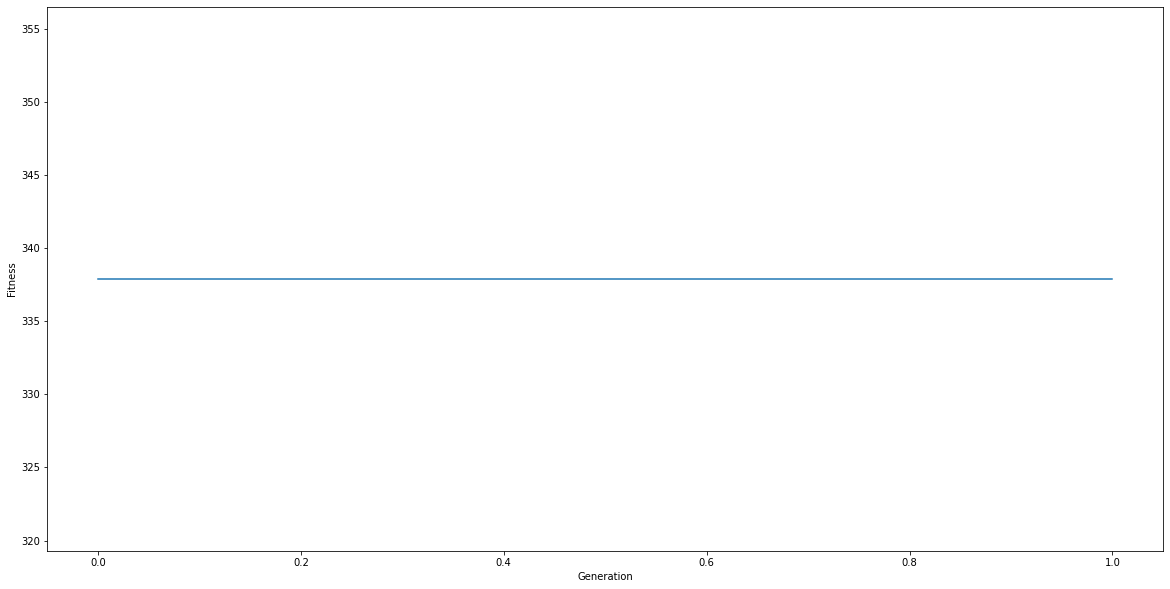

In [71]:
plot_fitness(ALL_FITNESS)

## Saving the parameters

In [72]:
OP_FILE_NAME='E:\Research\Statue gen output\\NewEA_7_withDelaunayVolume2020_.txt'

In [73]:
with open(OP_FILE_NAME, 'w') as f:
        f.writelines(str(PARAMS))

## Visualizing in 3D plot

In [74]:
BEST_FITNESS

[7, 7]

In [75]:
len(BEST_FITNESS)

2

In [76]:
GENS=[0,50,100,150,200,250,300]

In [77]:
TOP_FITNESS=[]

In [78]:
for g in GENS:
    TOP_FITNESS.append(BEST_FITNESS[g])

TOP_FITNESS

IndexError: list index out of range

In [ ]:
fig = plt.figure(figsize=(20,20))
for i,m in enumerate(TOP_FITNESS):
    model=PARAMS[GENS[i]][m][8][0]
    
    x=[m[0] for m in model]
    y=[m[1] for m in model]
    z=[m[2] for m in model]
    
    ax = fig.add_subplot(3, 3, i+1, projection='3d')
    ax.scatter3D(x,y,z,color="red",depthshade=False,s=50,edgecolor="black")
    ax.title.set_text(f"GENERATION-{GENS[i]}")
    
plt.show()